In [20]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("feyzazkefe/trashnet")

print("Path to dataset files:", path)

import shutil
import os

# Ensure only the 'dataset-resized' folder is placed in the project root
root_dir = os.getcwd()
src_dataset_dir = os.path.join(path, "dataset-resized")
alt_src_dataset_dir = os.path.join(root_dir, "1", "dataset-resized")
dest_dataset_dir = os.path.join(root_dir, "dataset-resized")

# Prefer moving from an existing '1/dataset-resized' if present to avoid duplicates
if os.path.exists(alt_src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    shutil.move(alt_src_dataset_dir, dest_dataset_dir)
    # Remove empty '1' dir if it's now empty
    try:
        os.rmdir(os.path.join(root_dir, "1"))
    except OSError:
        pass
    print("Dataset moved from '1' to:", dest_dataset_dir)
elif os.path.exists(src_dataset_dir):
    if os.path.exists(dest_dataset_dir):
        shutil.rmtree(dest_dataset_dir)
    # Copy the dataset instead of moving it due to read-only filesystem
    shutil.copytree(src_dataset_dir, dest_dataset_dir)
    print("Dataset copied to:", dest_dataset_dir)
else:
    raise FileNotFoundError("No 'dataset-resized' folder found in download path.")

Using Colab cache for faster access to the 'trashnet' dataset.
Path to dataset files: /kaggle/input/trashnet
Dataset copied to: /content/dataset-resized


================= Identificación de las clases del dataset =================
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
================= Análisis de tipos y tamaños de imagen =================
Formatos de imagen encontrados:
  .jpg: 2527 imágenes

Tamaños de imagen encontrados (ancho × alto):
  512×384: 2527 imágenes

Cantidad total de imágenes analizadas: 2527
Cantidad de tamaños distintos: 1

================= Distribución de colores por clase =================



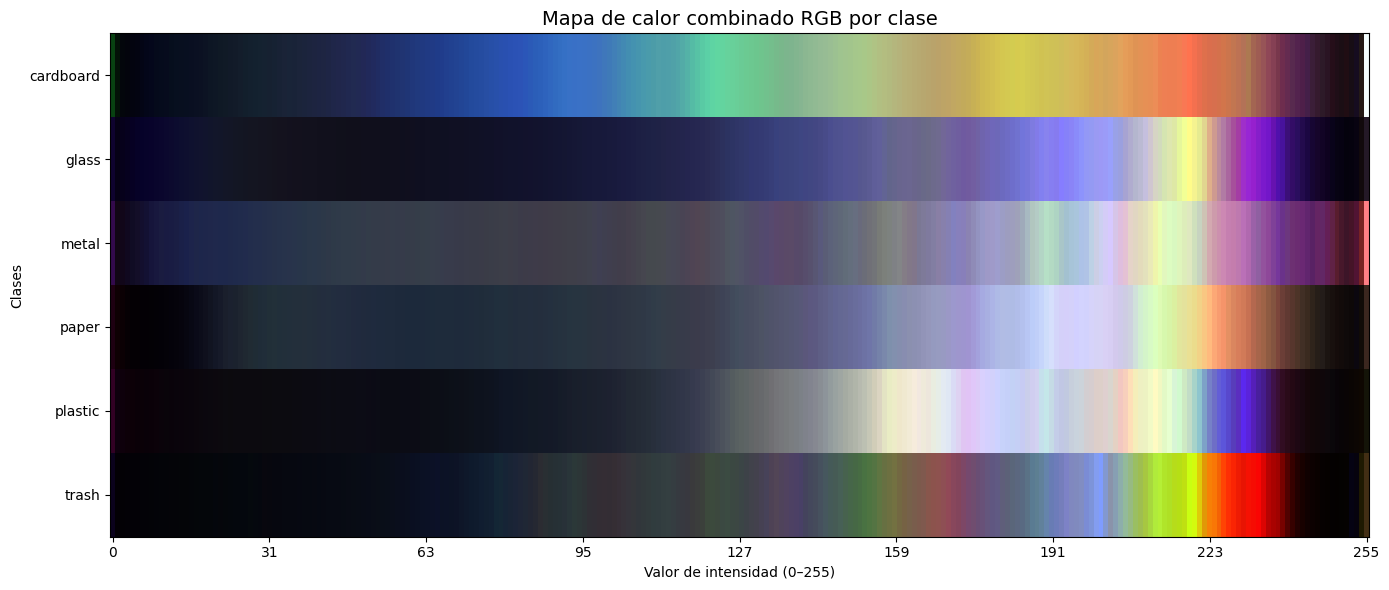

In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# ===== CONFIGURACIÓN =====
root_dir = "/content"
dataset_path = os.path.join(root_dir, "dataset-resized")
image_exts = (".jpg", ".png", ".jpeg")

# ===== CHEQUEO DEL DATASET =====
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f" No se encontró el dataset en: {dataset_path}")

classes = sorted([c for c in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, c))])
print("================= Identificación de las clases del dataset =================")
print("Classes:", classes)

# ===== CÁLCULO DE DISTRIBUCIÓN RGB =====
color_distributions = {}

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    if len(images) == 0:
        print(f"Clase '{cls}' sin imágenes válidas")
        continue

    hist_sum = np.zeros((256, 3))
    count = 0

    for filename in images:
        image_path = os.path.join(class_path, filename)
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error al leer {image_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [256], [0, 256])
            hist_sum[:, i] += hist.flatten()
        count += 1

    if count > 0:
        hist_avg = hist_sum / count
        # Normalizamos cada canal entre 0 y 1
        hist_norm = hist_avg / hist_avg.max(axis=0)
        color_distributions[cls] = hist_norm
# Inicializamos contadores
format_counter = Counter()
size_counter = Counter()

print("================= Análisis de tipos y tamaños de imagen =================")

for cls in sorted(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, cls)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(image_exts)]

    for filename in images:
        image_path = os.path.join(class_path, filename)
        ext = os.path.splitext(filename)[-1].lower()
        format_counter[ext] += 1

        img = cv2.imread(image_path)
        if img is not None:
            h, w = img.shape[:2]
            size_counter[(w, h)] += 1
        else:
            print(f" No se pudo leer: {image_path}")

# Mostrar conteo de formatos
print("Formatos de imagen encontrados:")
for ext, count in format_counter.items():
    print(f"  {ext}: {count} imágenes")


# Mostrar tamaños únicos
print("\nTamaños de imagen encontrados (ancho × alto):")
for (w, h), count in size_counter.most_common():
    print(f"  {w}×{h}: {count} imágenes")

print("\nCantidad total de imágenes analizadas:", sum(format_counter.values()))
print("Cantidad de tamaños distintos:", len(size_counter))


# ===== COMBINACIÓN RGB EN UN SOLO MAPA =====
# Creamos una "imagen" donde cada fila es una clase y las columnas representan valores de 0–255
height = len(color_distributions)
width = 256
combined_img = np.zeros((height, width, 3))

for idx, cls in enumerate(color_distributions):
    combined_img[idx, :, :] = color_distributions[cls]

# ===== VISUALIZACIÓN =====
print("\n================= Distribución de colores por clase =================\n")
plt.figure(figsize=(14, 6))
plt.imshow(combined_img, aspect='auto')
plt.yticks(range(len(color_distributions)), list(color_distributions.keys()))
plt.xticks(np.linspace(0, 255, 9), [f"{int(v)}" for v in np.linspace(0, 255, 9)])
plt.title("Mapa de calor combinado RGB por clase", fontsize=14)
plt.xlabel("Valor de intensidad (0–255)")
plt.ylabel("Clases")
plt.tight_layout()
plt.show()


Total de imágenes: 2527
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


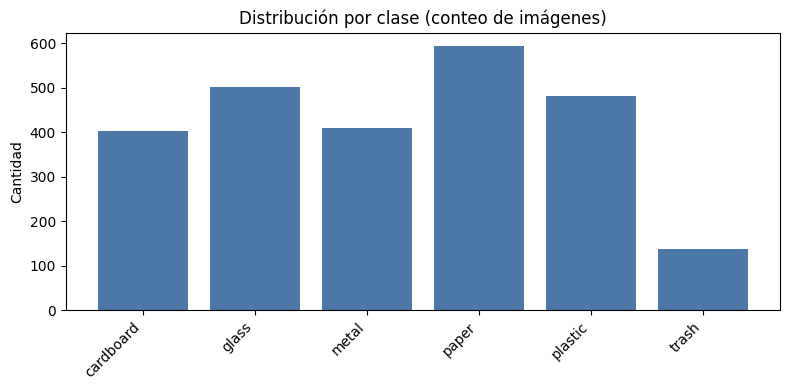

In [7]:
%matplotlib inline
import os
import matplotlib.pyplot as plt

# Ubicación del dataset
root_dir = os.getcwd()
dataset_dir = os.path.join(root_dir, "dataset-resized")

if not os.path.isdir(dataset_dir):
    raise FileNotFoundError(f"No se encontró 'dataset-resized' en: {dataset_dir}")

image_exts = (".jpg",)
class_to_count = {}

# Contar imágenes por clase (una subcarpeta por clase)
for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    num_images = sum(
        1 for f in os.listdir(class_path)
        if f.lower().endswith(image_exts)
    )
    class_to_count[class_name] = num_images

# Mostrar conteos
total_images = sum(class_to_count.values())
print("Total de imágenes:", total_images)
for cls, cnt in class_to_count.items():
    print(f"{cls}: {cnt}")

# Gráfico de barras
plt.figure(figsize=(8, 4))
plt.bar(list(class_to_count.keys()), list(class_to_count.values()), color="#4C78A8")
plt.title("Distribución por clase (conteo de imágenes)")
plt.ylabel("Cantidad")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
